In [1]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

from datetime import timedelta
from frvrs_utils import FRVRSUtilities
from notebook_utils import NotebookUtilities
import humanize
import matplotlib.pyplot as plt
import os
import os.path as osp
import re

nu = NotebookUtilities(
    data_folder_path=osp.abspath('../data'),
    saves_folder_path=osp.abspath('../saves')
)
fu = FRVRSUtilities(
    data_folder_path=osp.abspath('../data'),
    saves_folder_path=osp.abspath('../saves')
)
PNG_PATH = '../saves/png'
os.makedirs(name=PNG_PATH, exist_ok=True)


# Visualize DM/Patient Interactions

In [3]:

# Attempt to load the logs data frame
frvrs_logs_df = nu.load_data_frames(frvrs_logs_df='frvrs_logs_df')['frvrs_logs_df']
print(frvrs_logs_df.shape)

Attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/frvrs_logs_df.pkl.
Argument 'placement' has incorrect type (expected pandas._libs.internals.BlockPlacement, got slice)
No pickle exists for frvrs_logs_df - attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/frvrs_logs_df.csv.
(829116, 114)



## Visualize the Order of Responder Negotiations on one scene's timeline

In [4]:

# Group each patient, run, and session with non-null patient IDs
start_stop_list = ['SESSION_END', 'SESSION_START']
patient_mask_series = frvrs_logs_df.action_type.isin(fu.responder_negotiations_list + start_stop_list)
scene_gb = frvrs_logs_df[patient_mask_series].sort_values(['action_tick']).groupby(fu.scene_groupby_columns)

# Loop through each unique file/scene/patient combination
time_groups_dict = {}
consecutive_time_groups_dict = {}
for (session_uuid, scene_id), scene_df in scene_gb:
    key = (session_uuid, scene_id)
    actions_list = []
    action_types_set = set()
    for row_index, row_series in scene_df.iterrows():
        action_type = row_series.action_type
        actions_list.append(action_type)
        action_types_set.add(action_type)
    time_groups_dict[key] = actions_list
    for action_type in action_types_set: actions_list = fu.replace_consecutive_elements(actions_list, element=action_type)
    consecutive_time_groups_dict[key] = actions_list

{'TAG_APPLIED', 'SESSION_END', 'TOOL_APPLIED', 'PATIENT_ENGAGED', 'SESSION_START', 'INJURY_TREATED', 'PULSE_TAKEN'}


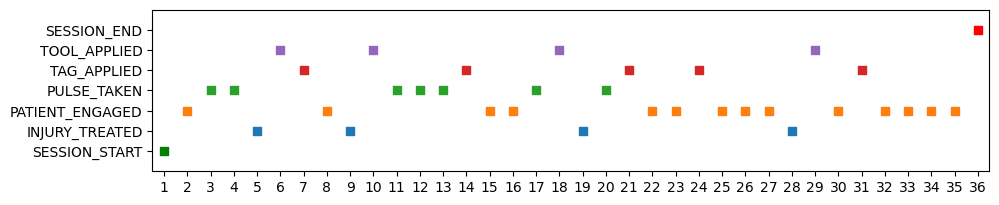

In [5]:

# Plot the action type sequence with a specific number of negotiations
scene_tuple, sequence = [(k, v) for k, v in time_groups_dict.items() if len(v) == 36][0]
color_dict = {'SESSION_START': 'green', 'SESSION_END': 'red'}
print(nu.get_alphabet(sequence))
if(sequence): plt = nu.plot_sequence(sequence, color_dict=color_dict, verbose=False);

{'PATIENT_ENGAGED x1', 'SESSION_END x1', 'PULSE_TAKEN x8', 'PULSE_TAKEN x2', 'TAG_APPLIED x1', 'PULSE_TAKEN x1', 'INJURY_TREATED x2', 'PULSE_TAKEN x11', 'PULSE_TAKEN x4', 'TOOL_APPLIED x1', 'PULSE_TAKEN x7', 'TAG_APPLIED x2', 'INJURY_TREATED x1', 'PULSE_TAKEN x3', 'SESSION_START x1'}


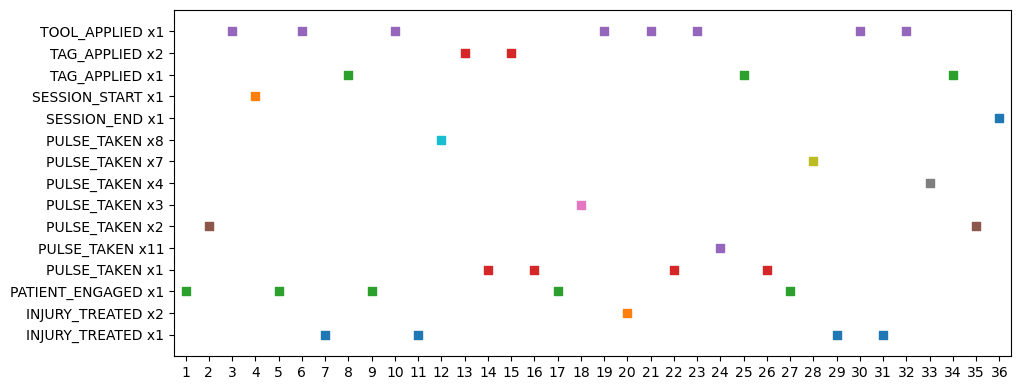

In [6]:

# Plot the consecutive time groups sequence with the fewest number of groupings
scene_tuple, sequence = [(k, v) for k, v in consecutive_time_groups_dict.items() if len(v) == 36][0]
color_dict = {'SESSION_START': 'green', 'SESSION_END': 'red'}
print(nu.get_alphabet(sequence))
if(sequence): plt = nu.plot_sequence(sequence, color_dict=color_dict, verbose=False);